In [2]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import neurokit2 as nk
import random
import pyhrv
from scipy.signal import find_peaks

# PPG preprocessing

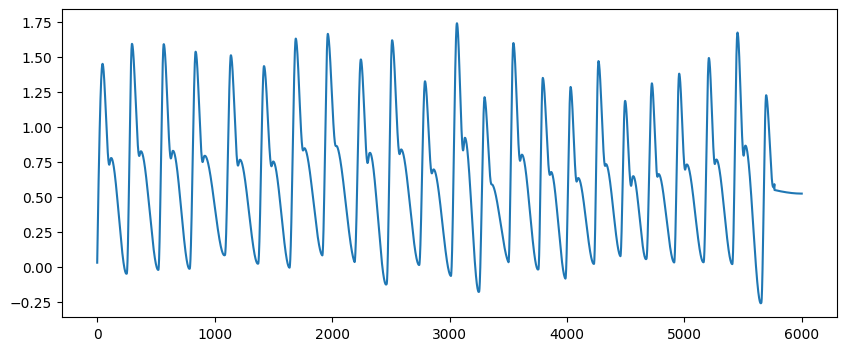

In [16]:
ppg = nk.ppg_simulate(duration=20, sampling_rate= 300, heart_rate=70)
data = pd.DataFrame({"PPG": ppg,})
plt.figure(figsize=(10,4))
plt.plot(data)

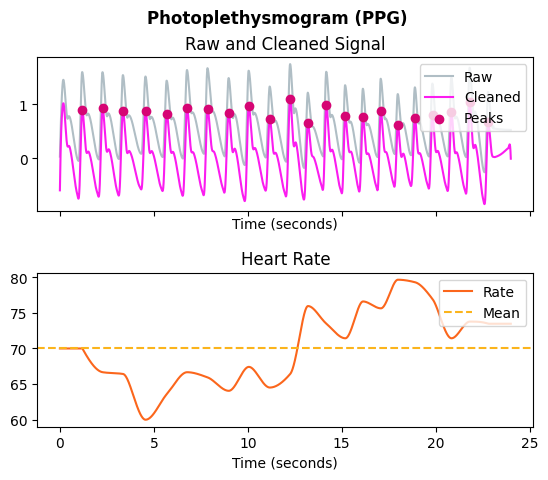

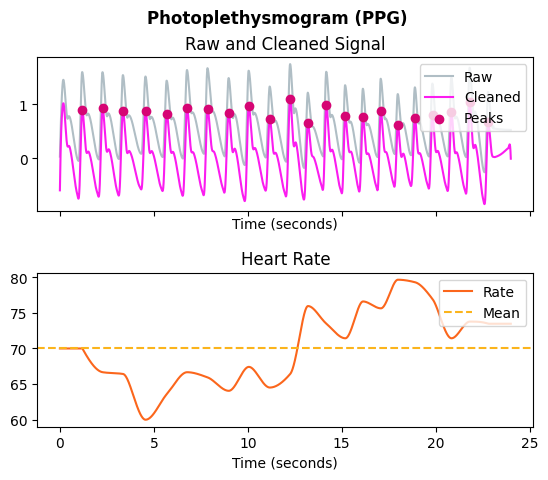

In [17]:
# Process it
signals, info = nk.ppg_process(data, sampling_rate=300)

# Visualize the processing
nk.ppg_plot(signals, sampling_rate=250)

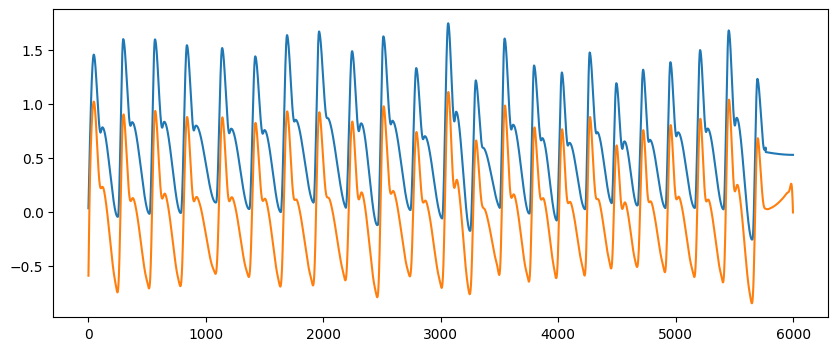

In [18]:
ppg_elgendi_clean = nk.ppg_clean(ppg, method='elgendi', sampling_rate=300)
ppg_nabian_clean = nk.ppg_clean(ppg, method='nabian2018')

signals_filtered = pd.DataFrame({'PPG_Raw' : ppg,
                        'PPG_Elgendi' : ppg_elgendi_clean,})
plt.figure(figsize=(10,4))
plt.plot(signals_filtered)


In [19]:
data = nk.data("bio_resting_5min_100hz")

event_time = []
for i in range(10):
    event_time.append(int((i/10)*len(data)))
print(event_time)

data_samp = data["PPG"]
df, info = nk.ppg_process(data["PPG"], sampling_rate=300)

# Visualize the processing
#nk.ppg_plot(df, sampling_rate=300)

epochs = nk.epochs_create(df, events=event_time, sampling_rate=100,
                          epochs_end=150)


features = nk.ppg_intervalrelated(epochs)
features_event = nk.ppg_eventrelated(epochs)
features.dropna(axis='columns')
features_event.dropna(axis='columns')
print(features)
print(features_event)

[0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000]
   Label  PPG_Rate_Mean  HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
1      1      99.058035  184.712500  62.345342         NaN         NaN   
2      2      95.316011  192.363636  64.160963         NaN         NaN   
3      3      91.439622  201.081081  90.875914         NaN         NaN   
4      4      91.844634  201.513514  89.874226         NaN         NaN   
5      5      94.345175  195.644737  89.911913         NaN         NaN   
6      6      97.354045  189.088608  82.915958         NaN         NaN   
7      7      80.215646  175.092308  46.057954         NaN         NaN   
8      8      64.271303  169.557692  41.515607         NaN         NaN   
9      9      43.453322  168.342857  41.453690         NaN         NaN   
10    10      21.325073  171.823529  41.438562         NaN         NaN   

    HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  ...  HRV_SampEn  \
1          NaN         NaN         NaN         NaN

Text(0, 0.5, '$EDA$')

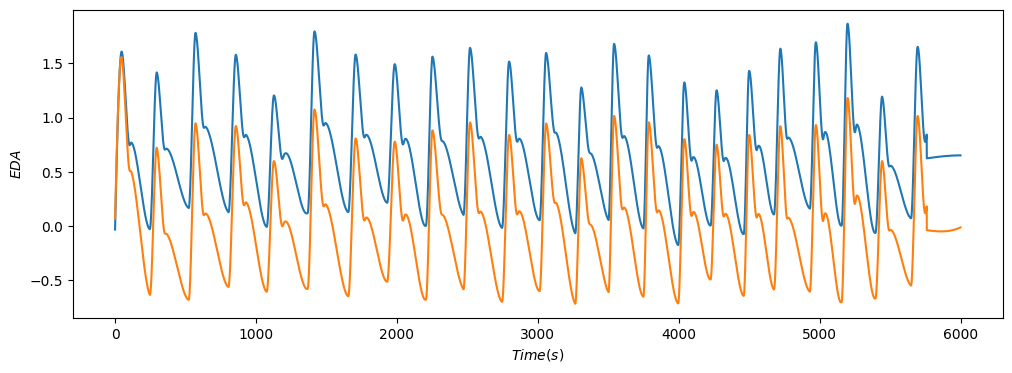

In [20]:
ppg = nk.ppg_simulate(duration=20, sampling_rate= 300, heart_rate=70)
data = pd.DataFrame({"PPG": ppg,})

############ lowpass filtering
# Parameters 
order = 5
frequency = 0.3
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).


# Filtering
b, a = scipy.signal.butter(order, frequency, btype='high')
eda_lp = scipy.signal.filtfilt(b, a, ppg)

# plot
plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(eda_lp)
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

# BVP data

In [125]:
def bvp_feat(data):
    #event_time = []
    features_bvp = None

    #for i in range(samples):
    #    event_time.append(int((i/samples)*len(data)))

    df, info = nk.ppg_process(data, sampling_rate=200)

    # Visualize the processing
    #nk.ppg_plot(df, sampling_rate=fs)

    #epochs = nk.epochs_create(df, events=[0,5000,10000,15000],epochs_start=0, epochs_end=5)

    #features_event = nk.ppg_eventrelated(epochs)
    features = nk.ppg_intervalrelated(df)

    #features_event.reset_index(drop=True, inplace=True)

    #features_bvp = pd.concat([features_event, features], axis = 1)
    #features_bvp = features_bvp.dropna(axis='columns')
    return features

In [87]:
def bvp_prep(data):
    data = data.dropna(axis='columns')
    features = data
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features = features.dropna(axis='columns')
    #features.drop(columns=features.columns[:2], axis=1,  inplace=True)
    #features = features.reset_index()
    return features

In [3]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                #assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [47]:
# Set up empty dataframes for the features
columns_ecg =['index', 'ecg_HR_mean', 'ecg_HR_min', 'ecg_HR_max', 'ecg_HR_std', 'ecg_SDNN', 'ecg_SDANN', 'ecg_RMSSD', 
                                           'ecg_SDSD','ecg_pNN50', 'ecg_pNN20', "ecg_triangular_index", "ecg_tinn", "ecg_sd1", "ecg_sd2",
                                            "ecg_ratio_sd2_sd1", 'ecg_abs_power_VLF', 'ecg_abs_power_LF', 'ecg_abs_power_HF', 'ecg_tot_power',
                                            'ecg_LF/HF', 'ecg_peak_vlf', 'ecg_peak_lf', 'ecg_peak_hf', 'ecg_norm_power_LF', 'ecg_norm_power_HF',
                                            'max_cwt_absmean', 'min_cwt_absmean', 'mean_cwt_absmean','std_cwt_absmean', 
                                            'max_cwt_std', 'min_cwt_std', 'mean_cwt_std','std_cwt_std',
                                            'max_cwt_energy', 'min_cwt_energy', 'mean_cwt_energy','std_cwt_energy',
                                            'max_cwt_var', 'min_cwt_var', 'mean_cwt_var','std_cwt_var',
                                            'entropy']
columns_resp = ['RSP_Rate_Mean','RRV_RMSSD', 'RRV_MeanBB', 'RRV_SDBB', 'RRV_SDSD', 'RRV_CVBB', 'RRV_CVSD', 'RRV_MedianBB',
                'RRV_MadBB', 'RRV_MCVBB', 'RRV_VLF', 'RRV_LF', 'RRV_HF', 'RRV_LFHF', 'RRV_LFn', 'RRV_HFn', 'RRV_SD1',
                'RRV_SD2', 'RRV_SD2SD1', 'RRV_ApEn', 'RRV_SampEn', 'RSP_Amplitude_Mean', 'RSP_RVT', 'RSP_Symmetry_PeakTrough',
                'RSP_Symmetry_RiseDecay', 'RSP_Phase_Duration_Inspiration', 'RSP_Phase_Duration_Expiration', 'RSP_Phase_Duration_Ratio']

columns = [*columns_ecg, *columns_resp]
ecgfeatures = pd.DataFrame(None, columns= columns)
edafeatures = None
bvpfeatures = None

print(len(ecgfeatures.keys()))
total_samples = 0
fs = 700 # sampling frequency
fs_bvp = 64
duration = 45
y = []
amountpsample = dict()
data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
#data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
# data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

for i in range(3): # 15 subjects
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(f"subject: {subject}")
    amountpsample[subject] = 0
    if subject != 'S12': # Skip S12, because it does not exist
        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        chest_data_dict = obj_data[subject].get_chest_data()
        wrist_data_dict = obj_data[subject].get_wrist_data()
        chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
        wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}

        # Get labels
        labels = obj_data[subject].get_labels()

        for label in [1,2,4]: # for every state of stress
            
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])

            # Obtaining the chest data
            eda_base=chest_data_dict['EDA'][baseline,0] # Select the EDA data
            ecg_base=chest_data_dict['ECG'][baseline,0] # Select the ECG data
            resp_base=chest_data_dict['Resp'][baseline,0] # Select the respiration data

            # Obtaining the wrist data
            baseline_BVP = baseline * fs_bvp // fs
            bvp_base=wrist_data_dict['BVP'][baseline_BVP,0] # Select the BVP data

                        # Multiple smaller samples per signal
            # samples = 10 # specify amount of samples

            for j in range(0, len(eda_base)//(duration*fs), 2): # loop over all segments
                amountpsample[subject] += 1
                # adding the labels to y
                if label==1 or label==4: # if amusement or medidation, classify as non-stress
                    y.append(0)
                else:
                    y.append(1)

                # Cutting the signal into a segment
                start, end = j*fs*duration, (j+1)*fs*duration
                ecg = ecg_base[start: end]
                eda = eda_base[start: end]
                bvp = bvp_base[start: end]

                # splitting sample into 10 smaller even-sized parts
                #ecg = ecg_base[int(len(ecg_base)* (j/samples)) : int(len(ecg_base)* ((j+1)/samples))]
                #eda = eda_base[int(len(eda_base)* (j/samples)) : int(len(eda_base)* ((j+1)/samples))]

                # getting the eda and ecg features
                index = subject + str(label) + str(j)
                #tonic, phasic, start, end = get_edaindex(eda, fs)
                #edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
                #ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)
                
                bvpfeature = bvp_feat(bvp)
                bvpfeatures = pd.concat([bvpfeatures, bvpfeature], axis=0)
    print(f"total samples {subject}: {amountpsample[subject]}")


71
subject: S2
total samples S2: 29
subject: S3
total samples S3: 29
subject: S4
total samples S4: 29


In [190]:
features_bvp_df1 = bvp_prep(bvpfeatures)
features_bvp_df1 = features_bvp_df1.drop(['HRV_HF', 'HRV_VHF', 'HRV_HFn', 'HRV_LnHF', 'HRV_MSE', 'HRV_CMSE', 'HRV_RCMSE'], axis=1)

    PPG_Rate_Mean  HRV_MeanNN    HRV_SDNN   HRV_RMSSD    HRV_SDSD  HRV_CVNN  \
0       39.241758  158.010152   67.502834   94.322855   94.564299  0.427206   
0       33.305278  184.505952   72.963283   98.969541   99.266932  0.395452   
0       34.545522  178.154286   65.518306   90.223445   90.483734  0.367762   
0       34.834493  178.754286   86.340493  120.072248  120.418751  0.483012   
0       30.280934  208.253333  159.418961  183.933622  184.553678  0.765505   
..            ...         ...         ...         ...         ...       ...   
0       29.919456  204.627451   61.184781   92.372245   92.676028  0.299006   
0       32.060219  191.773006   58.662700   87.065961   87.335862  0.305897   
0       33.686174  183.923077   57.985322   87.713617   87.974790  0.315269   
0       34.862042  178.194286   59.242798   89.041415   89.298254  0.332462   
0       32.641041  188.536145   57.846258   87.853632   88.120239  0.306818   

    HRV_CVSD  HRV_MedianNN  HRV_MadNN  HRV_MCVNN  .

C:\Users\JackC\AppData\Local\Temp\ipykernel_24348\2459201643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([np.inf, -np.inf], np.nan, inplace=True)


In [283]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(features_bvp_df1)
features_bvp_df = scaler.transform(features_bvp_df1)

In [281]:
from sklearn.model_selection import train_test_split
#x_train, x_test, Y_train, Y_test = train_test_split(features_bvp_df, y, test_size=0.15,shuffle=False, random_state=3)

In [305]:
from sklearn.linear_model import LogisticRegression
# define the model
logistic_model = LogisticRegression()
# fit/train the model on all features
logistic_model.fit(features_bvp_df, y)

Y_test_pred = logistic_model.predict(features_data)

# # score
log_score = logistic_model.score(features_data,Y_test)
print(log_score)

ValueError: Found input variables with inconsistent numbers of samples: [5, 6]

In [302]:
print(Y_test)
print(Y_test_pred)

[0, 0, 0, 1, 1]
[0 1 0 0 0]


In [301]:
Y_test = [0,0,0,1,1,1]

In [304]:
from sklearn import preprocessing
features_data = scaler.transform(features_data)

In [264]:
features_red_l= pd.DataFrame()

In [307]:
features_data = features_red_l

In [308]:
features_red1 = bvp_feat(-red_filt)
features_red = bvp_prep(features_red1)

features_red_l = pd.concat([features_red_l, features_red], axis=0)
print(features_red_l)

   PPG_Rate_Mean  HRV_MeanNN   HRV_SDNN  HRV_RMSSD   HRV_SDSD  HRV_CVNN  \
0      73.954139  164.764706  49.838374  57.125476  57.705318  0.302482   
0      74.382255  165.740000  40.815568  77.721507  78.515494  0.246263   
0      77.312612  159.176471  46.221945  73.021915  73.665421  0.290382   
0      74.469907  166.500000  43.855165  85.040327  85.904551  0.263394   
0      79.947239  154.185185  36.213765  71.100513  71.774598  0.234872   
0      79.947239  154.185185  36.213765  71.100513  71.774598  0.234872   
0      79.947239  154.185185  36.213765  71.100513  71.774598  0.234872   

   HRV_CVSD  HRV_MedianNN  HRV_MadNN  HRV_MCVNN  ...  HRV_FuzzyEn    HRV_CD  \
0  0.346709         144.0    28.1694   0.195621  ...     0.429497  0.909652   
0  0.468936         152.0    40.0302   0.263357  ...     0.390874  0.892272   
0  0.458748         176.0    78.5778   0.446465  ...     0.240094  0.425632   
0  0.510753         150.5    43.7367   0.290609  ...     0.239979  0.706044   
0  0

C:\Users\JackC\AppData\Local\Temp\ipykernel_24348\2459201643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([np.inf, -np.inf], np.nan, inplace=True)


# PPG sample data

In [1]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import neurokit2 as nk
import random
import pyhrv
from scipy.signal import find_peaks

<Figure size 2000x400 with 0 Axes>

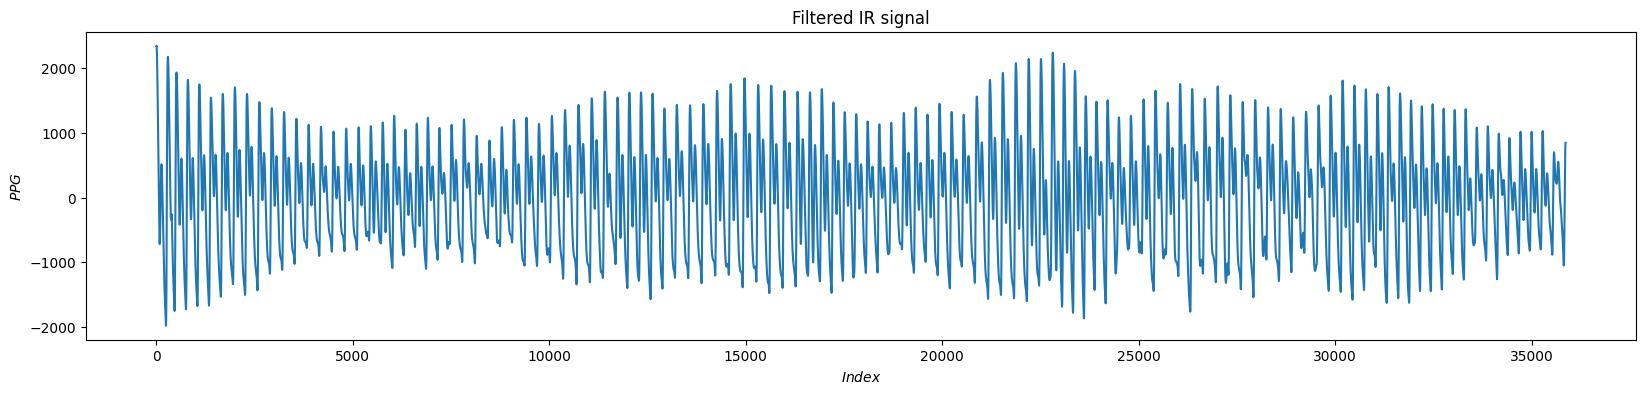

In [8]:
PPG_data = pd.read_csv('C:/Users/JackC/Documents/EPO4-C2/Testday_2/Subject_1/Nicky-stresstest_stroop.csv')

def sensorPPGfilter(data):
    fs = 400
    ir_data = data.iloc[100:,[3]]

    plt.figure(figsize=(20,4))
    #plt.plot(ir_data)
    # labels and titles
    #plt.title('Raw IR signal')
    #plt.xlabel('$Index$') 
    #plt.ylabel('$PPG$') 
    #plt.figure(figsize=(20,4))

    ir_data_clean = nk.ppg_clean(ir_data, method='nabian2018', sampling_rate=1000)

    # Parameters 
    order = 4
    frequency = np.array([0.5,10])
    sampling_rate = 300
    frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

    # Filtering
    b, a = scipy.signal.butter(order, frequency, btype='band')
    ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

    peaks_red, _ = find_peaks(np.array(ir_filt), height=0, distance=0.5*fs)
    peaks_red_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

    ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)[peaks_red_min[0]-1:peaks_red_min[-1]-1]
    peaks_red, _ = find_peaks(np.array(ir_filt), height=0, distance=0.5*fs)
    peaks_red_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

    # plot
    plt.figure(figsize=(20,4))
    #plt.plot((red_data-red_data.iloc[0,0]))
    plt.plot(-ir_filt)
    #plt.plot(peaks_red, red_filt[peaks_red], "x")
    #plt.plot(peaks_red_min, red_filt[peaks_red_min], "x")
    # labels and titles
    plt.title('Filtered IR signal')
    plt.xlabel('$Index$') 
    plt.ylabel('$PPG$') 
return -ir_filt

sensorPPGfilter(PPG_data)

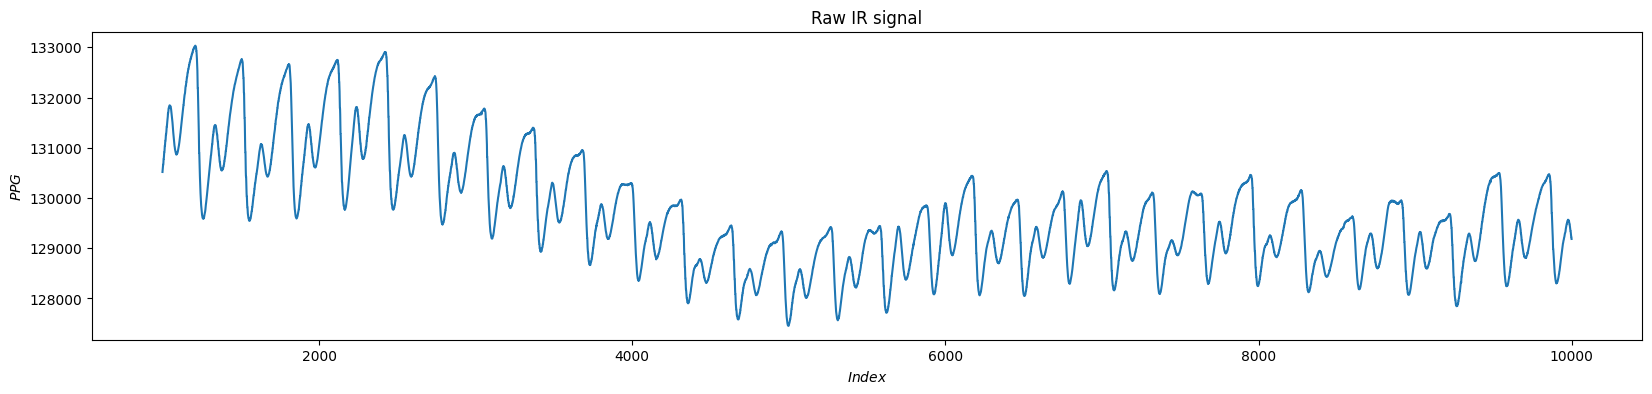

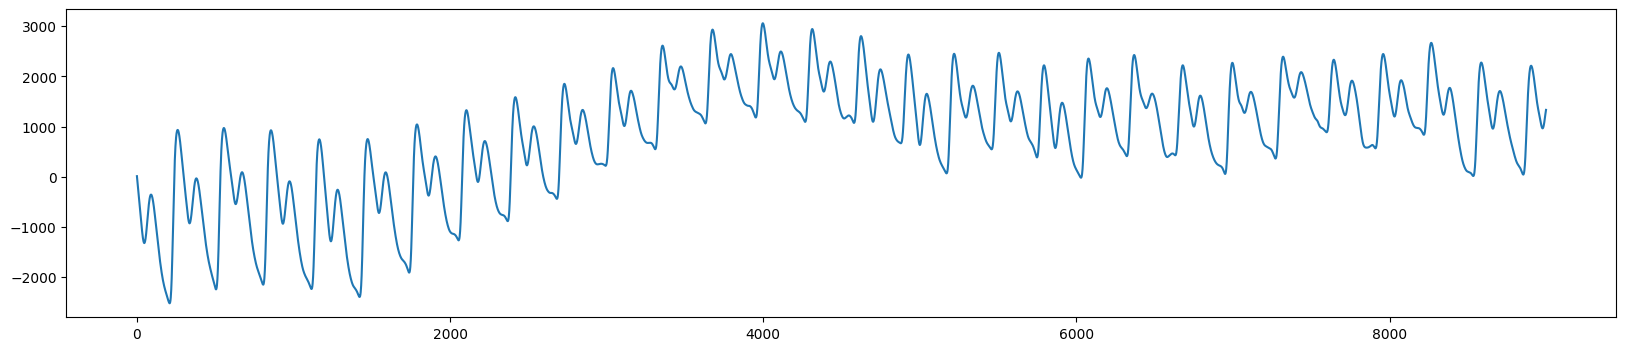

In [275]:
PPG_data = pd.read_csv('C:/Users/JackC/Documents/EPO4-C2/Testday_2/Subject_1/Nicky-stresstest_stroop.csv')
# daan quiz & rest 1
fs = 400

red_data = PPG_data.iloc[1000:10000,[3]]
ir_data = PPG_data.iloc[1000:10000,[4]]

plt.figure(figsize=(20,4))
plt.plot(red_data)
#plt.plot(ir_data)

red_data_clean = nk.ppg_clean(red_data, method='nabian2018', sampling_rate=1000)
#ir_data_clean = nk.ppg_clean(ir_data, method='nabian2018', sampling_rate=1000)
#ir_data_clean = nk.ppg_clean(ir_data_clean, method='nabian2018', sampling_rate=1000)

# labels and titles
plt.title('Raw IR signal')
plt.xlabel('$Index$') 
plt.ylabel('$PPG$') 
plt.figure(figsize=(20,4))
#plt.savefig("FawIRSignal.pdf", format="pdf", bbox_inches="tight")


#plt.plot(red_data.iloc[0,0] - red_data_clean)
#plt.plot(ir_data.iloc[0,0] - ir_data_clean)


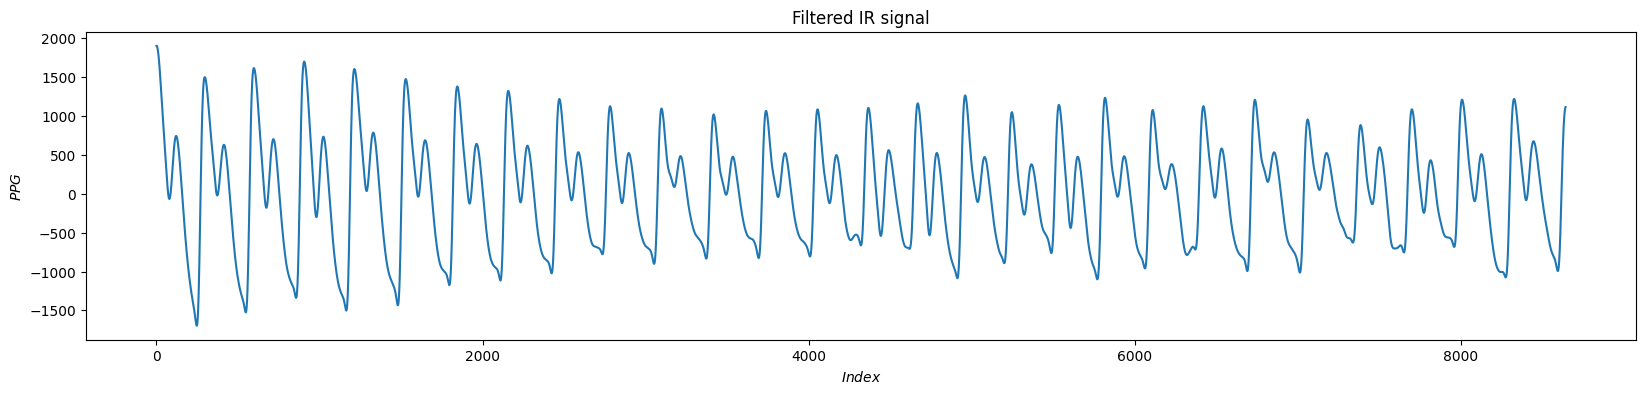

In [276]:
# Parameters 
order = 4
frequency = np.array([0.5,10])
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

# Filtering
b, a = scipy.signal.butter(order, frequency, btype='band')
red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)

peaks_red, _ = find_peaks(np.array(red_filt), height=0, distance=0.5*fs)
peaks_red_min, _ = find_peaks(-red_filt, height=0, distance=0.5*fs)

red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)[peaks_red_min[0]-1:peaks_red_min[-1]-1]
peaks_red, _ = find_peaks(np.array(red_filt), height=0, distance=0.5*fs)
peaks_red_min, _ = find_peaks(-red_filt, height=0, distance=0.5*fs)

# plot
plt.figure(figsize=(20,4))
#plt.plot((red_data-red_data.iloc[0,0]))
plt.plot(-red_filt)
#plt.plot(peaks_red, red_filt[peaks_red], "x")
#plt.plot(peaks_red_min, red_filt[peaks_red_min], "x")
# labels and titles
plt.title('Filtered IR signal')
plt.xlabel('$Index$') 
plt.ylabel('$PPG$') 

plt.savefig("FilterIRSignal.pdf", format="pdf", bbox_inches="tight")

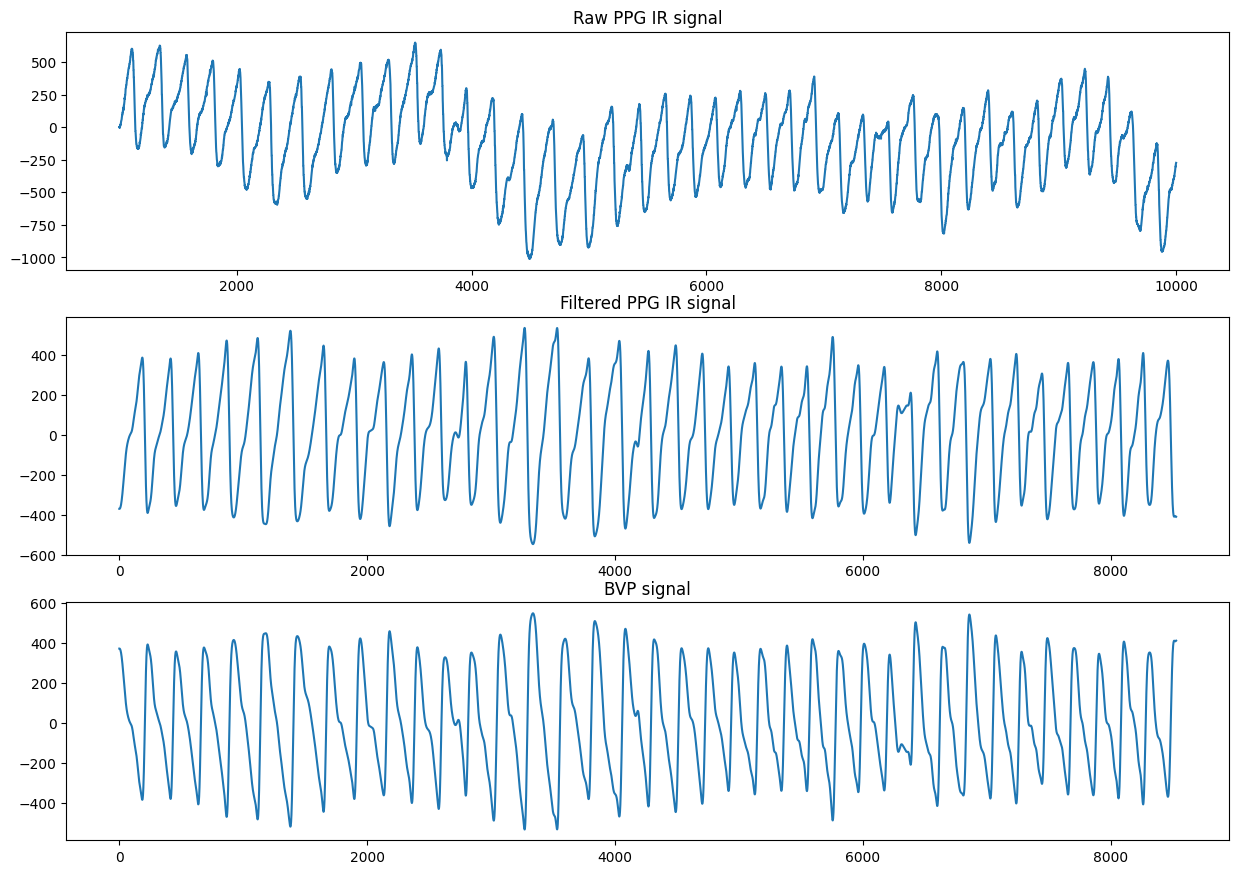

In [217]:
fig, axs = plt.subplots(3, figsize=(15, 10.5))

axs[0].plot(red_data-red_data.iloc[0,0])
axs[0].set_title('Raw PPG IR signal')
axs[1].plot(red_filt)
axs[1].set_title("Filtered PPG IR signal")
axs[2].plot(-red_filt)
axs[2].set_title("BVP signal")
plt.savefig("IRsignals.pdf", format="pdf", bbox_inches="tight")

In [15]:
red_filt_df = pd.DataFrame(red_filt)
AC_red = red_filt[peaks_red][:] - red_filt[peaks_red_min][:]
print(np.mean(AC_red))
print(AC_red.shape)

4304.876226289855
(43,)


In [16]:
# Parameters 
frequency = 0.5
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)

DC_red = red_filt

Text(0, 0.5, '$EDA$')

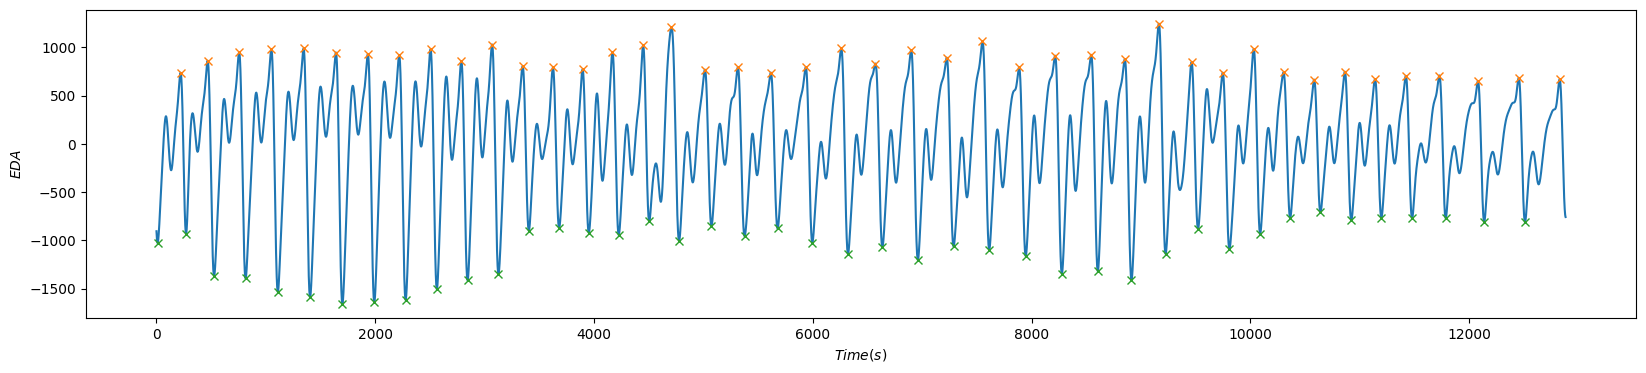

In [17]:
# Parameters 
order = 4
frequency = np.array([0.5,5])
#frequency = 0.5
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

# Filtering
b, a = scipy.signal.butter(order, frequency, btype='bandpass')
ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

peaks_ir, _ = find_peaks(ir_filt, height=0, distance=0.5*fs)
peaks_ir_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)[peaks_ir_min[0]-10:peaks_ir_min[-1]]
peaks_ir, _ = find_peaks(np.array(ir_filt), height=0, distance=0.5*fs)
peaks_ir_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

# plot
plt.figure(figsize=(20,4))
#plt.plot(ir_data-ir_data.iloc[0,0])
#plt.plot(ir_filt)
plt.plot(ir_filt)
plt.plot(peaks_ir, ir_filt[peaks_ir], "x")
plt.plot(peaks_ir_min, ir_filt[peaks_ir_min], "x")
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

In [18]:
AC_ir = ir_filt[peaks_ir][:] - ir_filt[peaks_ir_min][:]
print(AC_ir)

[1763.56299406 1791.75576431 2315.87546849 2371.60159104 2521.11116078
 2534.8643218  2586.22015047 2554.72553671 2595.49904466 2361.90487355
 2441.697399   2153.04899075 1689.51269958 1641.11621428 1870.35864646
 1963.97546831 2013.6501807  1771.4843107  1643.12930651 1693.53749332
 1671.08460877 2012.99315957 1971.94649069 2040.04354023 2096.35990995
 2125.03777603 1886.51173561 2073.84763067 2266.18466103 2194.40607403
 2652.69900987 1984.37155778 1616.23040258 2071.37598537 1669.96056452
 1430.62216442 1458.17787157 1463.96538237 1468.28869584 1480.61982534
 1419.96821895 1491.42193287 1478.5887374 ]


In [19]:
# Parameters 
frequency = 0.5
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

DC_ir = ir_filt

In [20]:
DC_mean_red_l = np.empty(0)
DC_mean_ir_l = np.empty(0)
for i in range(peaks_red_min.size):
    DC_mean_red = np.mean(DC_red[peaks_red_min[i]-100:peaks_red_min[i]+100])
    DC_mean_red_l = np.append(DC_mean_red_l, DC_mean_red)
    DC_mean_ir = np.mean(DC_ir[peaks_red_min[i]-100:peaks_red_min[i]+100])
    DC_mean_ir_l = np.append(DC_mean_ir_l, DC_mean_ir)

print(DC_mean_red_l.shape)
print(DC_mean_ir_l.shape)

(43,)
(43,)


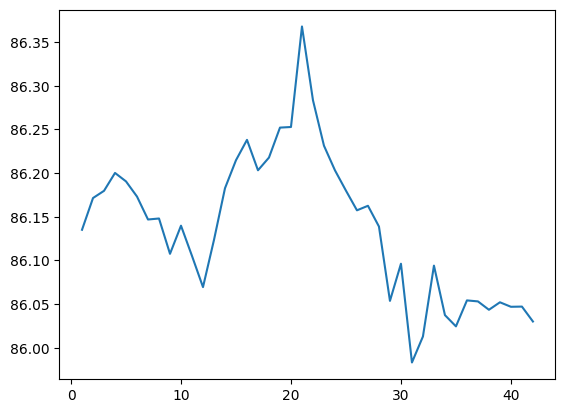

In [21]:
R = (AC_red[:] - DC_mean_red_l[:]) / (AC_ir[:] - DC_mean_ir_l[:])
SPO2 = 104 - 17 * R

plt.plot(SPO2)